In [33]:
import os
import sys
from time import sleep
import math
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

import torch
from torchvision.transforms import v2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
# import seaborn_image as isns
import tqdm.notebook as tqdm

sys.path.append('../dataset_construction')
from pano_utils import *
from panoseti_file_interfaces import ObservingRunInterface

%load_ext autoreload


from cnn_model import *
from data_loaders import *
from training_utils import *
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset CloudDetectionInference
    Number of datapoints: 934
    StandardTransform
Transform: Compose(
                 ToTensor()
                 ToDtype(scale=True)
           )


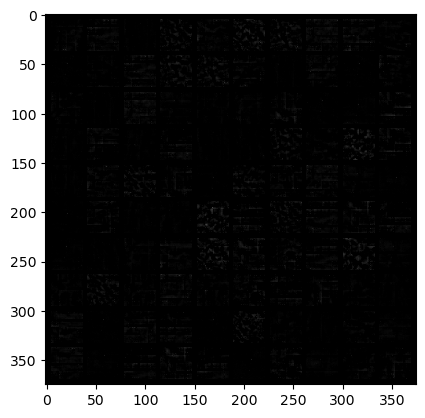

In [35]:
batch_size = 64
batch_id = 10
img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

transform = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float, scale=True)
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inference_data = CloudDetectionInference(
    batch_id = batch_id,
    transform = transform
)
inference_loader = torch.utils.data.DataLoader(
  dataset=inference_data,
  batch_size=batch_size
)
images = [inference_data[i][img_type] for i in np.random.choice(len(inference_data), size=min(100, len(inference_data)), replace=False)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)))
print(inference_data)

In [36]:
model = CloudDetection()
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model_2-24-24.pth'))
device = get_device()
model.to(device)
with open('../model_training/model_summary.txt', 'r') as f:
    # print(f.read())
    ...

In [37]:
# test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = np.array([], dtype=int)
true_labels = []
with torch.no_grad():
    model.eval() # Put model in eval mode
    for img_data in tqdm.tqdm(inference_loader, unit="batch"):
        x = img_data[img_type]
        x = x.float().to(device)
        pred = model(x)
        # predictions = torch.cat((predictions, torch.argmax(pred, dim=1)))
        predictions = np.concatenate((predictions, torch.argmax(pred, dim=1).to('cpu').numpy()))
inference_data.inference_session.add_labels(predictions)
get_path = inference_data.inference_session.get_pano_feature_fpath
print(predictions)

  0%|          | 0/15 [00:00<?, ?batch/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [38]:
labeled = inference_data.inference_session.labeled_df
cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']

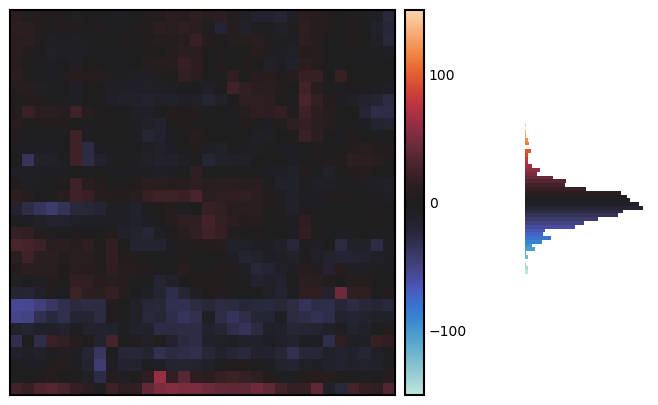

In [40]:
for fuid in cloudy['feature_uid']:
    data = np.load(get_path(fuid, img_type), allow_pickle=False)
    ObservingRunInterface.plot_image(
        data, bins=40, vmin=-150, vmax=150, cmap='icefire', perc=(0.5, 99.5)
    )
    display.clear_output(wait=True)
    plt.show()
    # i = input()
    plt.close()
    sleep(0.001)
    # if i != 'y':
        # break

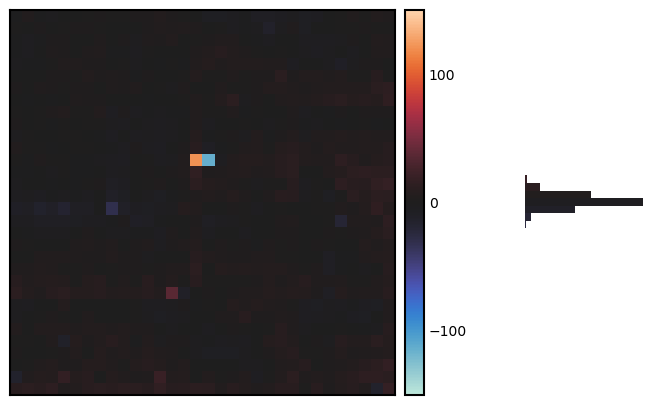

In [42]:
for fuid in clear['feature_uid']:
    data = np.load(get_path(fuid, img_type), allow_pickle=False)
    ObservingRunInterface.plot_image(
        data, bins=40, vmin=-150, vmax=150, cmap='icefire', perc=(0.5, 99.5)
    )
    display.clear_output(wait=True)
    plt.show()
    # i = input()
    plt.close()
    sleep(0.01)
    # if i != 'y':
        # break

In [159]:
def make_img_grid(label, cols=8, rows_per_plot=8):
    """Grid of all classified images labeled as the given label"""
    with_label = labeled.loc[labeled['label'] == label]
    # # skycam_uids_with_given_label = self.feature_df.loc[
    # #     (self.feature_df['feature_uid'].isin(feature_uids_with_given_label)), 'skycam_uid'
    # # ]
    # pano_uids_with_given_label = self.feature_df.loc[
    #     (self.feature_df['feature_uid'].isin(feature_uids_with_given_label)), 'pano_uid'
    # ]
    imgs = []

    for fuid in with_label['feature_uid']:
        data = np.load(get_path(fuid, img_type), allow_pickle=False)
        imgs.append(data)
    if len(imgs) == 0:
        print(f'No images labeled as "{label}"')
        return
    else:
        print(f'Images you classified as "{label}":')
    # Limit num rows in plot to ensure consistently-sized figures
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                feature_uid = with_label['feature_uid'].iloc[img_idx]
                ax.set_title(f'{23}{feature_uid[:6]}')  # Label each plot with first 6 chars of feature_uid
                ax.imshow(img, vmin=-150, vmax=150, cmap='icefire')
        plt.show()
        plt.close()


Images you classified as "clear_night_sky":


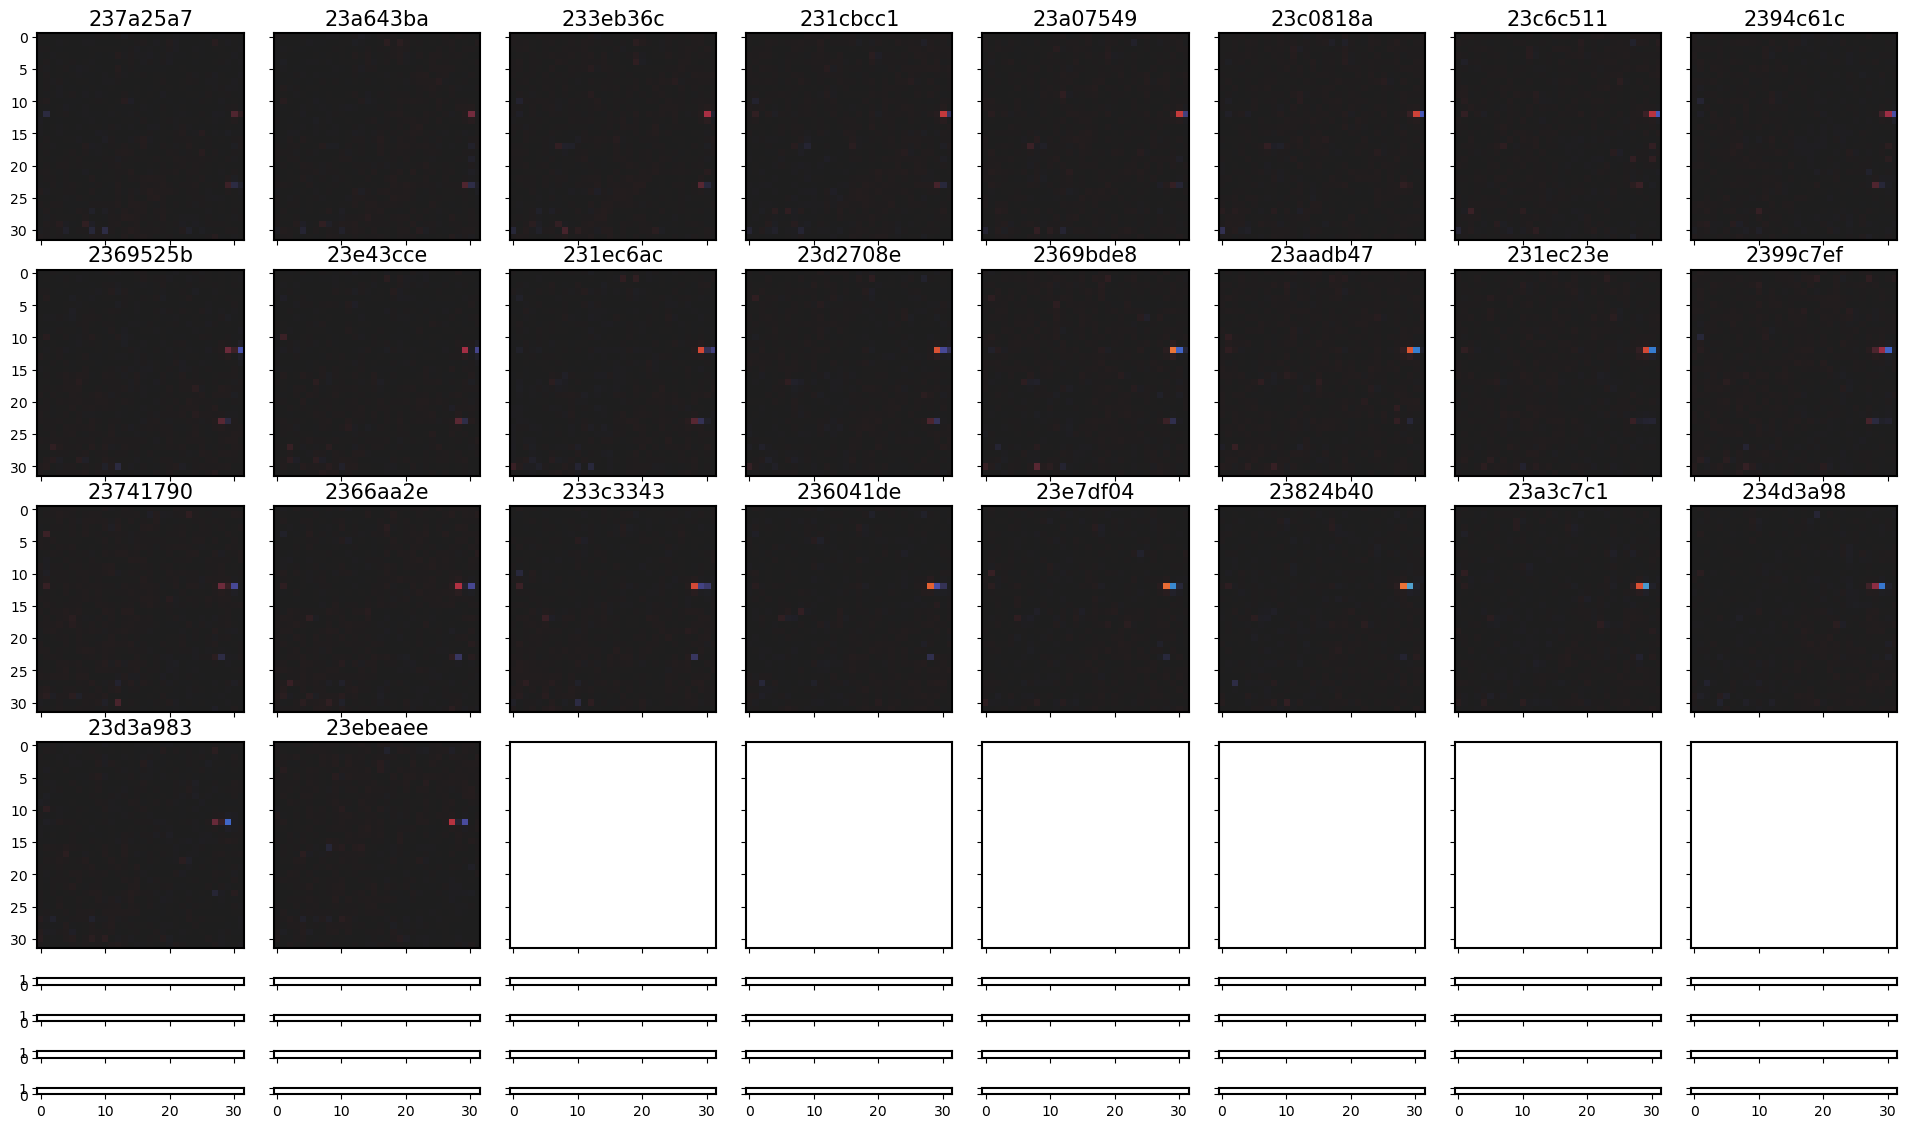

No images labeled as "not_clear_cloudy"


In [161]:
make_img_grid('clear_night_sky')
make_img_grid('not_clear_cloudy')